# Codificação de arquivos e operações pontuais

## Convertendo imagem

Importando bibliotecas e definindo variávies.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

file_name = "VisaoTrab1.tiff"
file_name_no_extension = os.path.splitext(file_name)[0]

Abrindo o arquivo "VisaoTrab1.tiff".

In [2]:
img = cv2.imread(file_name)

Criando arquivos JPEG - 10, 50 e 90%

In [3]:
created_files = []
for quality in [10, 50, 90]:
    created_files += [f'{file_name_no_extension}_{quality}.jpg']
    cv2.imwrite(created_files[-1], img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])

Salvar imagem como TIFF - LZW.

In [4]:
created_files += [f'{file_name_no_extension}_LZW.tiff']
# cv2.imwrite(created_files[-1], img, [5])
# cv2.imwrite(created_files[-1], img, [int(cv2.TIFFTAG_COMPRESSION), 5])
cv2.imwrite(created_files[-1], img)

True

Agora analisando o tamanho dos arquivos:

In [5]:
file_size = os.path.getsize(file_name)
created_files_sizes = [os.path.getsize(x) for x in created_files]

table_values = []
table_values += [(file_name, file_size, 100, 0, 0, 0)]

def get_channel(image, channel_number):
    channel_cn = np.zeros(image.shape[:2])
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            channel_cn[x, y] = image[x, y][channel_number]
    return channel_cn

original_channel = [get_channel(img, x) for x in range(3)]

# print(f"Tamanho do arquivo original ({file_name}): {file_size} bytes.")
for i in range(len(created_files)):
    img_temp = cv2.imread(created_files[i])
    temp_channel = [get_channel(img_temp, x) for x in range(3)]
    temp_size = os.path.getsize(created_files[i])
    table_values += [(created_files[i], temp_size, 100.0 * temp_size / file_size, 
        mean_squared_error(original_channel[0], temp_channel[0]),
        mean_squared_error(original_channel[1], temp_channel[1]),
        mean_squared_error(original_channel[2], temp_channel[2]))]

print(";".join(['    Nome do arquivo', ' Tamanho', '   %  ', 'EQM(B)', 'EQM(G)', 'EQM(R)']))
for x in table_values:
    print(f"{x[0]:19s};{x[1]:8d};{x[2]:6.2f};{x[3]:6.2f};{x[4]:6.2f};{x[5]:6.2f}")

print("\nNome do arquivo, tamanho do arquivo em bytes, percentual do tamanho do arquivo original, média do erro quadrático para os canais BGR")

    Nome do arquivo; Tamanho;   %  ;EQM(B);EQM(G);EQM(R)
VisaoTrab1.tiff    ;  786754;100.00;  0.00;  0.00;  0.00
VisaoTrab1_10.jpg  ;    6823;  0.87; 70.02; 38.63; 51.05
VisaoTrab1_50.jpg  ;   13226;  1.68; 11.03;  7.73; 10.07
VisaoTrab1_90.jpg  ;   35895;  4.56;  4.09;  2.80;  3.36
VisaoTrab1_LZW.tiff;  319636; 40.63;  0.00;  0.00;  0.00

Nome do arquivo, tamanho do arquivo em bytes, percentual do tamanho do arquivo original, média do erro quadrático para os canais BGR


------
## Correção gama

Convertento a imagem para HSV.

In [6]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

Valor gamma e constante com o valor máximo para o canal H.

In [7]:
gamma = 0.2
channel_max = 179.0

Separando o canal H na variável channel_h.

In [14]:
channel_h = get_channel(hsv, 0) / channel_max

Aplicando operação gamma sobre todo o canal H.

In [9]:
channel_h = channel_h ** gamma * channel_max

Salvando na matrix.

In [10]:
for x in range(hsv.shape[0]):
    for y in range(hsv.shape[1]):
        hsv[x, y][0] = int(max(min(channel_h[x, y], channel_max), 0))

Convertendo imagem para BGR e salvando o arquivo.

In [11]:
img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
file_name_gamma = f'{file_name_no_extension}_{gamma}.tiff'
cv2.imwrite(file_name_gamma, img)


True

Fazendo o histograma.

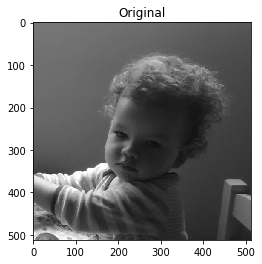

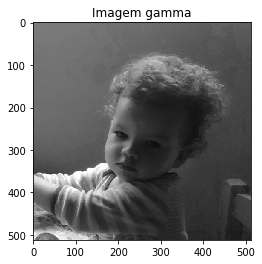

In [12]:
mpl.rc("savefig", dpi = 150)

image_titles = [(file_name, 'Original'), (file_name_gamma, 'Imagem gamma')]
images_rows_cols = []

for image_file_name, title in image_titles:
    img = cv2.imread(image_file_name, 0)
    rows, cols = img.shape
    images_rows_cols += [(img, rows, cols)]
    plt.imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.title(title)
    plt.show()

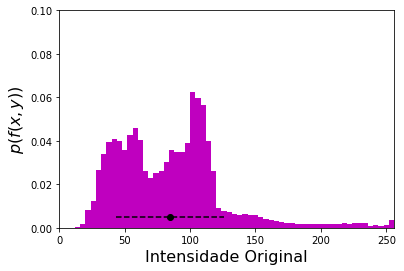


Media:  84.36088562011719
Desvio Padrao:  41.201500362409455


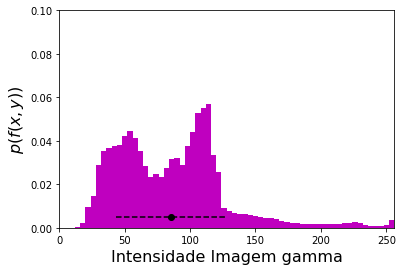


Media:  85.31911087036133
Desvio Padrao:  41.84318533750384


In [13]:
for i in range(len(image_titles)):
    img, rows, cols = images_rows_cols[i]
    image_file_name, title = image_titles[i]

    hist, bins = np.histogram(img, range=(0, 256), bins=64)
    hist = hist / float(rows * cols)
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', color='m', width=4)
    plt.xlim([0, 256])
    plt.ylim([0, 0.1])
    plt.ylabel('$p(f(x,y))$', fontsize=16)
    plt.xlabel(f'Intensidade {title}', fontsize=16)
    m_y = 0.005
    m = np.mean(img)
    s = np.std(img)
    plt.plot(m, m_y , "ko")
    plt.plot([m - s, m + s], [m_y] * 2, "k--");
    plt.savefig(f'{os.path.splitext(image_file_name)[0]}_Hist.eps')
    plt.show()
    print('\nMedia: ', np.mean(img))
    print('Desvio Padrao: ', np.std(img))